In [1]:
import warnings
warnings.simplefilter("ignore", category=UserWarning)
from fastai.vision.all import *
import pandas as pd
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt
import re
import tarfile
import random
import torch
import warnings
from pathlib import Path
from tqdm.notebook import tqdm

In [2]:
meta_path = '/kaggle/input/vggface2-test-112x112/meta/meta/identity_meta.csv'
train_dir = Path('/kaggle/input/vggface2/train')

# Load and clean metadata
df_meta = pd.read_csv(meta_path, quotechar='"', skipinitialspace=True)

# Clean up column names and strings 
df_meta['Class_ID'] = df_meta['Class_ID'].str.strip()
df_meta['Name'] = df_meta['Name'].str.strip().str.replace(' ', '_') 

# Create dictionary that maps folder names/IDs e.g., 'n000001' to real names 'A.J._Buckley'
id_to_name = dict(zip(df_meta['Class_ID'], df_meta['Name']))

# Build image dataframe
data = []
for class_folder in tqdm(train_dir.ls()):
    class_id = class_folder.name  
    
    # Check if name exists for this ID
    if class_id in id_to_name:
        real_name = id_to_name[class_id]
        
        # Get all images in this folder
        images = class_folder.ls()
        
        for img_path in images:
            data.append({
                'path': str(img_path),
                'label': real_name,
                'class_id': class_id
            })

df = pd.DataFrame(data)

print(f"Total images found: {len(df)}")
print(f"Shape of df: {df.shape}")
print(df.head())

  0%|          | 0/8631 [00:00<?, ?it/s]

Total images found: 3141890
Shape of df: (3141890, 3)
                                               path           label class_id
0  /kaggle/input/vggface2/train/n008215/0429_01.jpg  Stella_Tennant  n008215
1  /kaggle/input/vggface2/train/n008215/0432_01.jpg  Stella_Tennant  n008215
2  /kaggle/input/vggface2/train/n008215/0085_01.jpg  Stella_Tennant  n008215
3  /kaggle/input/vggface2/train/n008215/0030_01.jpg  Stella_Tennant  n008215
4  /kaggle/input/vggface2/train/n008215/0262_02.jpg  Stella_Tennant  n008215


In [4]:
# Group by label and sample 100 images per person
images_per_person = 100   

# Filter df to only include large enough classes
label_counts = df['label'].value_counts()
labels_to_keep = label_counts[label_counts >= images_per_person].index
df_filtered = df[df['label'].isin(labels_to_keep)]

df_balanced = df_filtered.groupby('label').sample(n=images_per_person, replace=False, random_state=42)
df_balanced = df_balanced.reset_index(drop=True)

print(f"Classes: {df_balanced['label'].nunique()}")
print(f"Total images: {len(df_balanced)}")

Classes: 8630
Total images: 863000


In [5]:
datablock = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_x=ColReader('path'),     
    get_y=ColReader('label'),
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    item_tfms=Resize(224),
    batch_tfms=aug_transforms()
)
dls = datablock.dataloaders(df_balanced, bs=128, num_workers=2)

Batch from dataloaders:


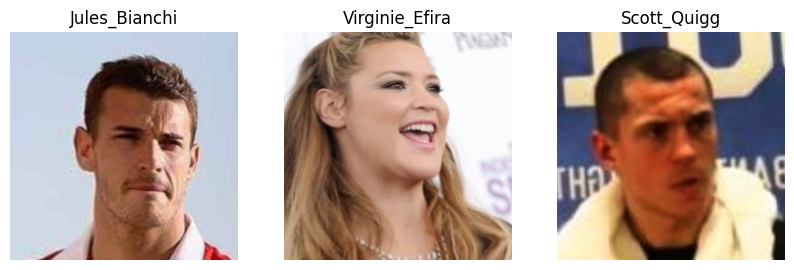

In [6]:
print("Batch from dataloaders:")
dls.show_batch(max_n=3, figsize=(10,10))
plt.show()

In [7]:
learn = vision_learner(
    dls, 
    resnet18,  
    metrics=accuracy,
    loss_func=LabelSmoothingCrossEntropy()
)

learn.fine_tune(
    epochs=12,       
    base_lr=3e-3, 
    freeze_epochs=1,
    cbs=[
        SaveModelCallback(monitor='accuracy', fname='best_similarity_prediction_model'),
        EarlyStoppingCallback(monitor='accuracy', min_delta=0.001, patience=3)
    ]
)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 203MB/s]


epoch,train_loss,valid_loss,accuracy,time
0,7.440145,6.791679,0.086906,1:19:36


Better model found at epoch 0 with accuracy value: 0.08690614253282547.


epoch,train_loss,valid_loss,accuracy,time
0,6.282507,5.343579,0.303447,35:40
1,5.539720,4.467152,0.413453,35:43
2,5.202704,4.022642,0.473969,35:01
3,4.839980,3.604504,0.557439,35:28
4,4.558722,3.342101,0.605452,35:06
5,4.331633,3.160490,0.649496,34:58
6,4.129955,2.976849,0.688893,35:57
7,3.903465,2.875780,0.716744,36:42
8,3.734039,2.787006,0.746199,35:06
9,3.637190,2.750283,0.775104,35:29


Better model found at epoch 0 with accuracy value: 0.30344727635383606.
Better model found at epoch 1 with accuracy value: 0.413453072309494.
Better model found at epoch 2 with accuracy value: 0.4739687144756317.
Better model found at epoch 3 with accuracy value: 0.5574391484260559.
Better model found at epoch 4 with accuracy value: 0.6054519414901733.
Better model found at epoch 5 with accuracy value: 0.6494959592819214.
Better model found at epoch 6 with accuracy value: 0.6888933777809143.
Better model found at epoch 7 with accuracy value: 0.7167439460754395.
Better model found at epoch 8 with accuracy value: 0.7461993098258972.
Better model found at epoch 9 with accuracy value: 0.775104284286499.
Better model found at epoch 10 with accuracy value: 0.7975839972496033.
Better model found at epoch 11 with accuracy value: 0.8064889907836914.


In [8]:
learn.export('model_resnet18_similarity_prediction.pkl')